In [1]:
import random
import math
import sqlite3
import timeit
from collections import namedtuple
from dataclasses import dataclass
from random import shuffle
from matplotlib import pyplot as plt

from ducks import Dex, FrozenDex
from odex import IndexedSet, HashIndex, attr, literal

In [2]:
import platform, psutil, sys

print("platform:\t", platform.system())
print("release:\t", platform.release())
print("architecture:\t", platform.machine())
print("processor:\t", platform.processor())
print("RAM:\t\t", f"{round(psutil.virtual_memory().total / (1024.0 **3))} GB")
print("Python version:\t", sys.version)

platform:	 Darwin
release:	 23.4.0
architecture:	 x86_64
processor:	 i386
RAM:		 32 GB
Python version:	 3.10.1 (main, Jan 20 2022, 09:22:54) [Clang 13.0.0 (clang-1300.0.18.6)]


In [3]:
@dataclass(frozen=True)
class X:
    a: int
    b: int
    c: int

    def __hash__(self):
        return hash(id(self))
        
def measure(func, n=100):
    timer = timeit.Timer(func)
    return min(timer.repeat(repeat=n, number=1))
    
def compare(objs):
    iset = IndexedSet(objs, [HashIndex("a"), HashIndex("b"), HashIndex("c")])

    db = sqlite3.connect(":memory:")
    db.execute("CREATE TABLE objs (id INT PRIMARY KEY, a INT, b INT, c INT)")
    db.execute("CREATE INDEX idx_a ON objs (a)")
    db.execute("CREATE INDEX idx_b ON objs (b)")
    db.execute("CREATE INDEX idx_c ON objs (c)")
    db.executemany("INSERT INTO objs (id, a, b, c) VALUES (?, ?, ?, ?)", [(i, x.a, x.b, x.c) for i, x in enumerate(objs)])

    dex = Dex(objs, ["a", "b", "c"])

    fdex = FrozenDex(objs, ["a", "b", "c"])

    plan = iset.optimize(iset.plan("a = 0 AND b = 0 AND c = 0"))
    
    return {
        "odex IndexedSet": measure(lambda: iset.filter("a = 0 AND b = 0 AND c = 0")),
        "odex IndexedSet (pre-planned)": measure(lambda: iset.execute(plan)),
        "ducks Dex": measure(lambda: set(dex[{"a": 0, "b": 0, "c": 0}])),
        "ducks FrozenDex": measure(lambda: set(fdex[{"a": 0, "b": 0, "c": 0}])),
        "sqlite": measure(lambda: {objs[i] for i, in db.execute("SELECT id FROM objs WHERE a = 0 AND b = 0 AND c = 0").fetchall()}),
        "set comprehension": measure(lambda: {x for x in objs if x.a == 0 and x.b == 0 and x.c == 0}),
    }

def graph(x, data, title, ignore=()):
    for key in data[0].keys():
        if key in ignore:
            continue
        y = [d[key] * 1000 for d in data]
        plt.plot(x, y, label=key)
    
    plt.xlabel("Total number of objects in collection")
    plt.ylabel("Time (ms)")
    plt.title(title)
    plt.legend()
    
    plt.show()

In [4]:
n = [100, 1000, 10000, 100000, 1000000]
match_one_hundred = [compare([X(a=i % 100, b=i % 100, c=i % 100) for i in range(i)]) for i in n]

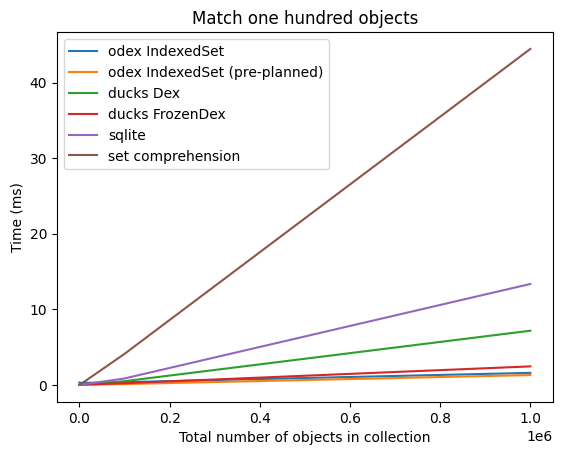

In [5]:
graph(n, match_one_hundred, "Match one hundred objects")